<a href="https://colab.research.google.com/github/virainmalhotra/Breast_Cancer_Classification_XGBoost/blob/main/TS_Forecast1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [2]:
Data = pd.read_csv("carbon_output.csv")
df = Data[['ticker','year','carbon']]
df['year'] = df['year'].astype(str) + '-01-01'
df['year'] = pd.to_datetime(df['year'])
df_company = df[df['ticker']=='ibm.us']
df = df_company[['year','carbon']]
df.set_index('year',inplace= True)
df.sort_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

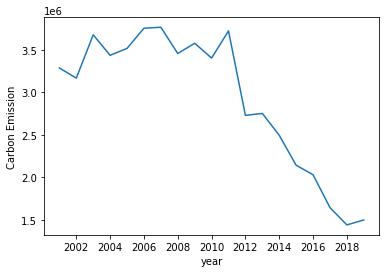

In [3]:
plt.xlabel("year")
plt.ylabel("Carbon Emission")
plt.plot(df)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


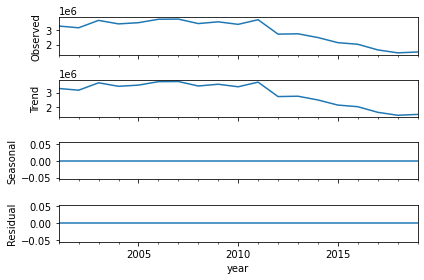

In [5]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df, model = 'additive')
fig = decomposition.plot()
plt.show()

In [4]:
#determine rolling statistics
rolmean = df.rolling(window=4).mean()
rolstd = df.rolling(window=4).std()
print(rolmean,rolstd)

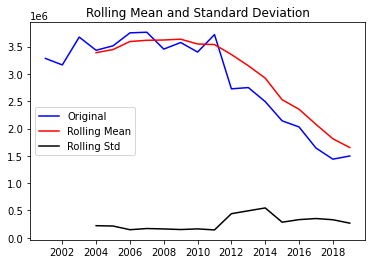

In [6]:
#plot rolling statistics:
orig = plt.plot(df,color='blue',label = 'Original')
mean = plt.plot(rolmean,color='red',label = 'Rolling Mean')
std = plt.plot(rolstd,color = 'black',label= 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)
#since Mean and Standard Deviation is not constant: The data is not stationary

In [7]:
#Perform Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(df['carbon'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput["Critcal Value (%s)"%key]=value
print(dfoutput)
#Since p value is large and Test Statistics is greater than Critical Value, we can't reject the H0

Results of Dickey-Fuller Test:
Test Statistics                 0.866820
p-value                         0.992642
#Lags Used                      1.000000
Number of Observations Used    17.000000
Critcal Value (1%)             -3.889266
Critcal Value (5%)             -3.054358
Critcal Value (10%)            -2.666984
dtype: float64


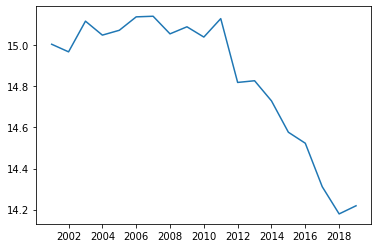

In [8]:
#Estimating the trend
#WE are taking the log of our dataset
df_log = np.log(df)
plt.plot(df_log)

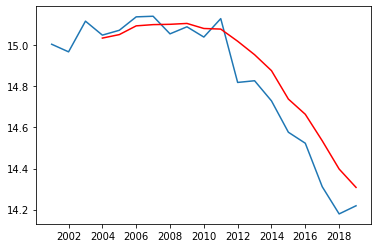

In [9]:
#Rolling Stats of log scale
movingAverage = df_log.rolling(window=4).mean()
movingSTD = df_log.rolling(window=4).std()
plt.plot(df_log)
plt.plot(movingAverage,color='red')
#again a downward trend, not stationary

In [11]:
datasetlogscaleMinusmovingAverage = df_log - movingAverage
datasetlogscaleMinusmovingAverage.head(5)

#Remove Nan Values
datasetlogscaleMinusmovingAverage.dropna(inplace=True)
datasetlogscaleMinusmovingAverage.head()

,carbon
year,
2004-01-01,0.014446
2005-01-01,0.021021
2006-01-01,0.043789
2007-01-01,0.040800
2008-01-01,-0.046434


In [14]:
def test_stationarity(timeseries):
  #Determining Rolling Statistics
  movingAverage = timeseries.rolling(window=4).mean()
  movingSTD = timeseries.rolling(window=4).std()

  #plot rolling statistics
  orig = plt.plot(timeseries,color='blue',label = 'Original')
  mean = plt.plot(movingAverage,color='red',label = 'Rolling Mean')
  std = plt.plot(movingSTD,color = 'black',label= 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)
  
  #Perform Dickey Fuller Test:  
  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries['carbon'],autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput["Critcal Value (%s)"%key]=value
  print(dfoutput)

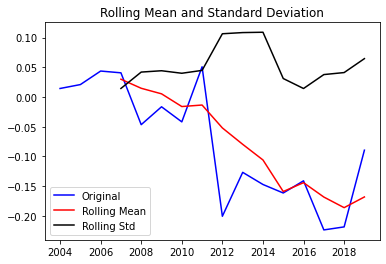

Results of Dickey-Fuller Test:
Test Statistics                -1.940522
p-value                         0.313245
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critcal Value (1%)             -3.964443
Critcal Value (5%)             -3.084908
Critcal Value (10%)            -2.681814
dtype: float64


In [15]:
test_stationarity(datasetlogscaleMinusmovingAverage)

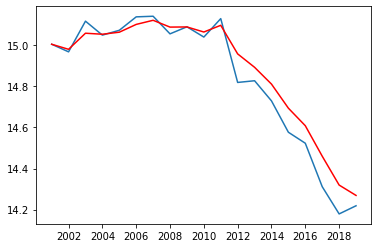

In [18]:
exponentialDecayWeightedAverage = df_log.ewm(halflife=1,min_periods=0,adjust=True).mean()
plt.plot(df_log)
plt.plot(exponentialDecayWeightedAverage,color='red')

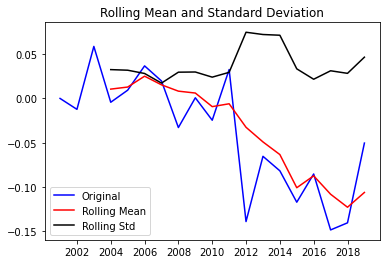

Results of Dickey-Fuller Test:
Test Statistics                -1.278432
p-value                         0.638981
#Lags Used                      6.000000
Number of Observations Used    12.000000
Critcal Value (1%)             -4.137829
Critcal Value (5%)             -3.154972
Critcal Value (10%)            -2.714477
dtype: float64


In [19]:
dflogMinusexponentialDecayWeightedAverage = df_log - exponentialDecayWeightedAverage
test_stationarity(dflogMinusexponentialDecayWeightedAverage)

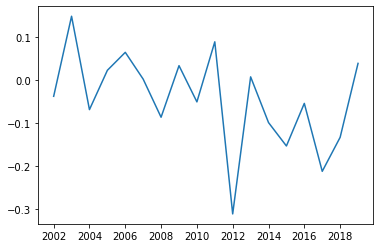

In [20]:
datasetLogDiffShifting=df_log-df_log.shift()
plt.plot(datasetLogDiffShifting)

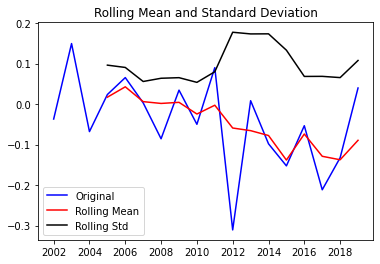

Results of Dickey-Fuller Test:
Test Statistics                -4.522808
p-value                         0.000179
#Lags Used                      0.000000
Number of Observations Used    17.000000
Critcal Value (1%)             -3.889266
Critcal Value (5%)             -3.054358
Critcal Value (10%)            -2.666984
dtype: float64


In [21]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

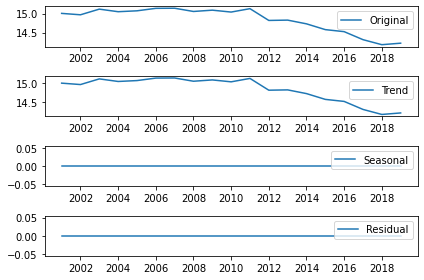

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()




/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

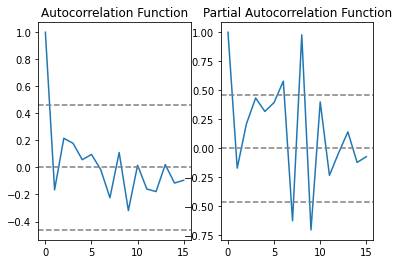

In [35]:
#ACF AND PACF
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(datasetLogDiffShifting,nlags=15)
lag_pacf = pacf(datasetLogDiffShifting,nlags=15,method='ols')

#Plot ACF FOR q
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF FOR p
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Plotting AR Model


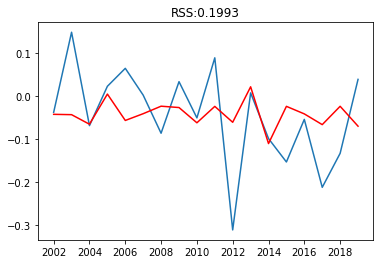

In [66]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model= ARIMA(df_log,order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS:%.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting['carbon'])**2))
print('Plotting AR Model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Plotting AR Model


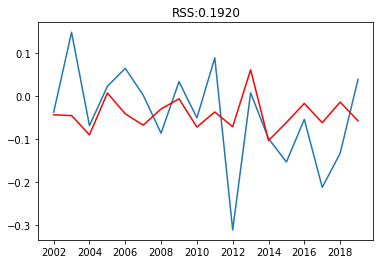

In [65]:
#MA MODEL
model= ARIMA(df_log,order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues,color='red')
plt.title('RSS:%.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting['carbon'])**2))
print('Plotting AR Model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Plotting ARIMA Model


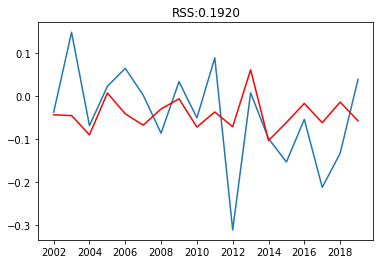

In [74]:
#ARIMA MODEL
model= ARIMA(df_log,order=(0,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['carbon'])**2))
print('Plotting ARIMA Model')

In [76]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff)

year
2002-01-01   -0.042796
2003-01-01   -0.044579
2004-01-01   -0.089398
2005-01-01    0.008028
2006-01-01   -0.040524
2007-01-01   -0.066920
2008-01-01   -0.029149
2009-01-01   -0.005625
2010-01-01   -0.071279
2011-01-01   -0.036225
2012-01-01   -0.070670
2013-01-01    0.062015
2014-01-01   -0.102608
2015-01-01   -0.060715
2016-01-01   -0.016258
2017-01-01   -0.061139
2018-01-01   -0.013183
2019-01-01   -0.056873
dtype: float64


In [77]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

year
2002-01-01   -0.042796
2003-01-01   -0.087375
2004-01-01   -0.176773
2005-01-01   -0.168745
2006-01-01   -0.209269
dtype: float64


In [79]:
predictions_ARIMA_log = pd.Series(df_log['carbon'].iloc[0],index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
2001-01-01    15.004751
2002-01-01    14.961955
2003-01-01    14.917376
2004-01-01    14.827978
2005-01-01    14.836006
dtype: float64

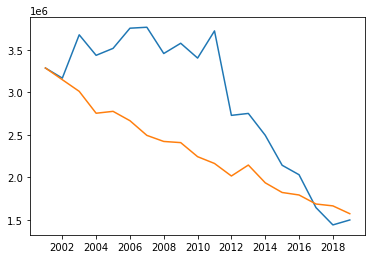

In [80]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

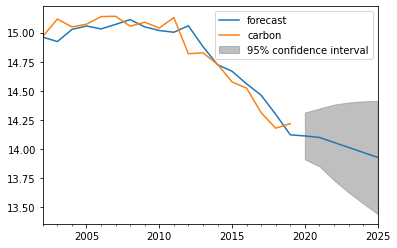

In [86]:
results_ARIMA.plot_predict(1,24)